In [1]:
from pyspark.sql import SparkSession

# Starting the Spark session
spark = SparkSession.builder \
    .appName("MovieLens-1M") \
    .getOrCreate()

# Loading the my dataset
df = spark.read.csv("/home/jovyan/data/1MMovieDataset.csv", header=True, inferSchema=True)


In [2]:
# Display the structure of the DataFrame, including column names and data types
df.printSchema()

# Show the first 5 rows of the dataset
df.show(5)


root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- imdb_rating: string (nullable = true)
 |-- imdb_votes: string (nullable = true)

+---+--------------------+------------+----------+--------+------------+--------+-------+--------+-----------------+----------+--------------------+-----------+----------+
| id|               title|vote_average|vote_count|  status|release_date| revenue|runtime|  budget|original_language|popularity|              genres|imdb_rating|imdb_votes|
+---+--------------------+------------+----------+--------+------------+--------

In [3]:
from pyspark.sql.functions import col, isnan, when, count

# In each column, count "null" or "NaN" values 
df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()


+---+-----+------------+----------+------+------------+-------+-------+------+-----------------+----------+------+-----------+----------+
| id|title|vote_average|vote_count|status|release_date|revenue|runtime|budget|original_language|popularity|genres|imdb_rating|imdb_votes|
+---+-----+------------+----------+------+------------+-------+-------+------+-----------------+----------+------+-----------+----------+
|  0|   14|           1|         1|     1|      111800|     10|      2|     1|                1|         1|292560|     604301|    604343|
+---+-----+------------+----------+------+------------+-------+-------+------+-----------------+----------+------+-----------+----------+



In [4]:
# Drop columns, cause high missing values and will not be used in analysis
df = df.drop("imdb_rating", "imdb_votes", "genres", "release_date")


In [5]:
df.printSchema() # showing the columns

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- status: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- popularity: string (nullable = true)



In [6]:
# In each column, count "null" or "NaN" values 
df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()

+---+-----+------------+----------+------+-------+-------+------+-----------------+----------+
| id|title|vote_average|vote_count|status|revenue|runtime|budget|original_language|popularity|
+---+-----+------------+----------+------+-------+-------+------+-----------------+----------+
|  0|   14|           1|         1|     1|     10|      2|     1|                1|         1|
+---+-----+------------+----------+------+-------+-------+------+-----------------+----------+



In [7]:
from pyspark.ml.feature import StringIndexer

# StringIndexer to convert language to "numerical index"
indexer = StringIndexer(inputCol="original_language", outputCol="language_index")
df = indexer.fit(df).transform(df)

# Showing the new column
df.select("original_language", "language_index").show(5)


+-----------------+--------------+
|original_language|language_index|
+-----------------+--------------+
|               fi|          29.0|
|               fi|          29.0|
|               en|           0.0|
|               en|           0.0|
|               en|           0.0|
+-----------------+--------------+
only showing top 5 rows



In [8]:
from pyspark.sql.functions import when

# Add a new column called rating_level based on vote_average
df = df.withColumn("rating_level",
    when(df["vote_average"] >= 8, "excellent")
    .when(df["vote_average"] >= 6, "good")
    .when(df["vote_average"] >= 4, "average")
    .otherwise("poor")
)

# Preview
df.select("vote_average", "rating_level").show(10)


+------------+------------+
|vote_average|rating_level|
+------------+------------+
|         7.1|        good|
|       7.293|        good|
|         5.9|     average|
|         6.5|        good|
|         7.5|        good|
|         6.8|        good|
|         8.2|   excellent|
|       7.816|        good|
|       8.468|   excellent|
|       8.006|   excellent|
+------------+------------+
only showing top 10 rows



In [9]:
df.printSchema() # showing the columns

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- status: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- language_index: double (nullable = false)
 |-- rating_level: string (nullable = false)



In [10]:
# Drop unnecessary columns again due to kernel reset
columns_to_drop = ["genres", "imdb_rating", "imdb_votes"]

# Create cleaned DataFrame
df_cleaned = df.drop(*columns_to_drop)

# Confirm structure is ready for HiveQL
df_cleaned.printSchema()


root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- status: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- language_index: double (nullable = false)
 |-- rating_level: string (nullable = false)



In [11]:
# Register the cleaned DataFrame as a temporary SQL view called "movies"
df_cleaned.createOrReplaceTempView("movies")
# This allows us to run SQL queries as if it were a Hive table

In [12]:
spark.sql("""
    SELECT original_language, COUNT(*) AS count
    FROM movies
    GROUP BY original_language
    ORDER BY count DESC
""").show()

+-----------------+------+
|original_language| count|
+-----------------+------+
|               en|520013|
|               fr| 65443|
|               es| 60359|
|               de| 48525|
|               ja| 45107|
|               zh| 38067|
|               pt| 33848|
|               ru| 24613|
|               it| 23886|
|               ko| 13370|
|               ar|  9820|
|               nl|  9414|
|               sv|  8954|
|               cs|  8924|
|               hi|  8678|
|               tr|  8142|
|               pl|  7568|
|               tl|  7281|
|               xx|  6697|
|               da|  5664|
+-----------------+------+
only showing top 20 rows



In [13]:
# Count how many movies are in each rating level
# Also calculate the average vote count per category
spark.sql("""
    SELECT rating_level,
           COUNT(*) AS movie_count,
           ROUND(AVG(vote_count), 2) AS avg_votes
    FROM movies
    GROUP BY rating_level
    ORDER BY avg_votes DESC
""").show()

+------------+-----------+---------+
|rating_level|movie_count|avg_votes|
+------------+-----------+---------+
|        good|     143276|    132.2|
|   excellent|      60170|    35.24|
|     average|     127253|    29.17|
|        poor|     717876|     0.24|
+------------+-----------+---------+



In [14]:
# Calculating the average runtime of all movies
spark.sql("""
    SELECT ROUND(AVG(runtime), 2) AS avg_runtime
    FROM movies
""").show()

+-----------+
|avg_runtime|
+-----------+
|      45.65|
+-----------+



In [15]:
# Importing of required libraries for ML
import pandas as pd  # for data handling
from pyspark.sql.functions import col   # column operation
from sklearn.model_selection import train_test_split   # data splitting
from sklearn.ensemble import RandomForestClassifier   # model training
from sklearn.metrics import classification_report, confusion_matrix   # model evauluation
from sklearn.preprocessing import LabelEncoder   # label encoding

In [19]:
from pyspark.sql.functions import when

# Create new rating_level column based on vote_average
df_cleaned = df_cleaned.withColumn(
    "rating_level",
    when(df_cleaned["vote_average"] >= 8, "excellent")
    .when(df_cleaned["vote_average"] >= 6, "good")
    .when(df_cleaned["vote_average"] >= 4, "average")
    .otherwise("poor")
)

In [20]:
from pyspark.ml.feature import StringIndexer

# Turning original_language into numeric column
indexer = StringIndexer(
    inputCol="original_language",
    outputCol="language_encoded",
    handleInvalid="keep"  # Keep null values as a category
)
df_encoded = indexer.fit(df_cleaned).transform(df_cleaned)

In [21]:
# Keeping only needed columns and move to pandas
pandas_df = df_encoded.select("runtime", "vote_count", "language_encoded", "rating_level").toPandas()

In [22]:
from sklearn.preprocessing import LabelEncoder

# Converting target column to numeric labels
le_rating = LabelEncoder()
pandas_df["rating_encoded"] = le_rating.fit_transform(pandas_df["rating_level"])

In [23]:
import pandas as pd

# Fix column types
pandas_df["runtime"] = pd.to_numeric(pandas_df["runtime"], errors="coerce")
pandas_df["vote_count"] = pd.to_numeric(pandas_df["vote_count"], errors="coerce")

# Fill missing values with 0
pandas_df.fillna(0, inplace=True)

In [24]:
from sklearn.model_selection import train_test_split

# Features and target
X = pandas_df[["runtime", "vote_count", "language_encoded"]]
y = pandas_df["rating_encoded"]

# Split training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
print(X_train.dtypes)
print(X_train.isnull().sum())
print(y_train.isnull().sum())


runtime             float64
vote_count          float64
language_encoded    float64
dtype: object
runtime             0
vote_count          0
language_encoded    0
dtype: int64
0


In [26]:
# Convert to numeric values (object → float)
X_train["runtime"] = pd.to_numeric(X_train["runtime"], errors="coerce")
X_train["vote_count"] = pd.to_numeric(X_train["vote_count"], errors="coerce")
X_test["runtime"] = pd.to_numeric(X_test["runtime"], errors="coerce")
X_test["vote_count"] = pd.to_numeric(X_test["vote_count"], errors="coerce")

# Fill missing values with 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


In [27]:
print(X_train.head())


        runtime  vote_count  language_encoded
408561    116.0         1.0              14.0
70143      11.0         3.0               0.0
708782     57.0         0.0               0.0
572694     63.0         0.0               1.0
774181      6.0         0.0               0.0


In [29]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict the results using the test set
y_pred = rf_model.predict(X_test)


In [30]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(838860, 3)
(838860,)
(209715, 3)
(209715,)


In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# Accuracy calculating
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8040
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.55      0.51     25531
           1       0.39      0.51      0.44     12065
           2       0.50      0.45      0.47     28888
           3       0.98      0.95      0.96    143231

    accuracy                           0.80    209715
   macro avg       0.59      0.61      0.60    209715
weighted avg       0.82      0.80      0.81    209715



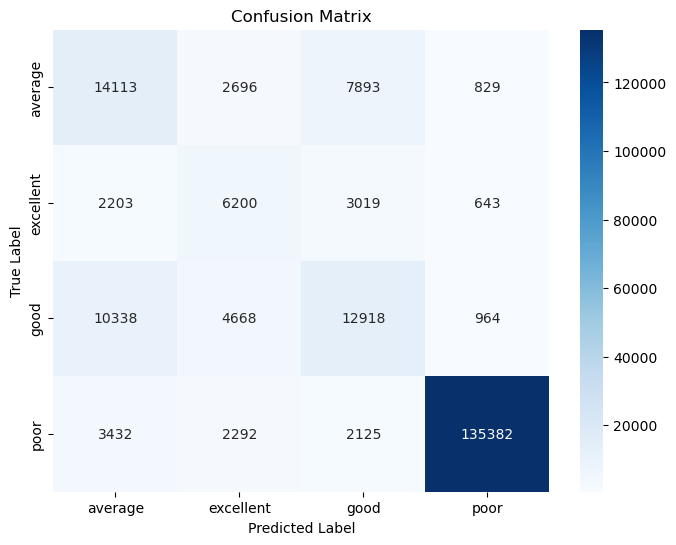

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_rating.classes_, yticklabels=le_rating.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

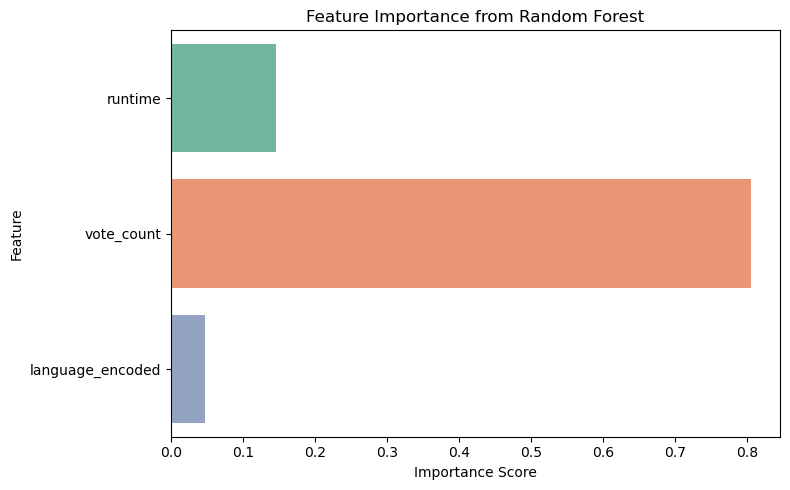

In [37]:
# plotting of feature importance from random forest and importance score
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names, hue=feature_names, dodge=False, palette="Set2", legend=False)
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()